In [12]:
%load_ext autoreload
%autoreload 2

In [154]:
import numpy as np
import pandas as pd
import cvxpy as cp
import multiprocessing
from multiprocessing import Pool
from functools import partial
from tqdm.notebook import tqdm
from choldate import cholupdate
from pycss.CSS import *
from pycss.subset_selection import *
from notebook_utils.utils import * 
from notebook_utils.data_generation import * 
from notebook_utils.missing_data import *
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def Sigma_MLE_from_MLE(MLE):
    
    noise = noise_from_MLE(MLE)
    p = np.sum(MLE['W_MLE'].shape)
    k = len(MLE['S_MLE'])
    
    Sigma_MLE = np.zeros((p, p))
    Sigma_MLE[:k, :k] = MLE['C_MLE'].copy()
    Sigma_MLE[k:, :k] = MLE['W_MLE'] @ MLE['C_MLE']
    Sigma_MLE[:k, k:] = Sigma_MLE[k:, :k].T.copy()
    Sigma_MLE[k:, k:] =  MLE['W_MLE'] @ MLE['C_MLE'] @ MLE['W_MLE'].T
    if noise == 'sph':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['sigma_sq_MLE'])
    if noise == 'diag':
        np.fill_diagonal(Sigma_MLE[k:, k:], np.diag(Sigma_MLE[k:, k:]) + MLE['D_MLE'])
    perm_in_place(Sigma_MLE, np.concatenate([MLE['S_MLE'], complement(p, MLE['S_MLE'])]), np.arange(p))
    
    return Sigma_MLE
    

# Synthetic Data Experiment

In [3]:
p = 20
k = 4
C_chol = get_equicorrelated_chol(k, 0.25, diag=1)
C = C_chol @ C_chol.T
sigma_sq = 0.2
    
W = get_block_W(p, k, num_blocks=2, block_size=3, overlap=2)

signs = np.array([[1, 1, 1, 0], 
                  [1, 1, -1, 0], 
                  [1, -1, 1, 0], 
                  [1, -1, -1, 0], 
                  [-1, 1, 1, 0],
                  [-1, 1, -1, 0], 
                  [-1, -1, 1, 0],
                  [-1, -1, -1, 0],
                  [0, 1, 1, 1], 
                  [0, 1, 1, -1], 
                  [0, 1, -1, 1], 
                  [0, 1, -1, -1], 
                  [0, -1, 1, 1],
                  [0, -1, 1, -1], 
                  [0, -1, -1, 1],
                  [0, -1, -1, -1]])

W *= signs
signal_sizes = np.sum(W * (W @ C), axis=1)
W = np.sqrt(1 - sigma_sq)/np.sqrt(signal_sizes)[:, None] * W
S = np.arange(k)

MLE = {'C_MLE': C,
       'W_MLE': W,
       'sigma_sq_MLE': sigma_sq,
       'S_MLE': np.arange(k)}

Sigma = Sigma_MLE_from_MLE(MLE)

B = 1000
n=200
num_inits=10
noise = 'sph'
q = 0.05

In [4]:
X_S = np.random.normal(0, 1, size=(B, n, k)) @ C_chol.T[np.newaxis, :, :]
X = generate_PCSS_data(X_S, W=W, sigma_sq=sigma_sq)
X[np.where(np.random.binomial(1, q, X.shape))] = np.nan
X_c = X - np.nanmean(X, axis = 1)[:, np.newaxis, :]

### Our Method

In [5]:
missing_data_search = partial(masked_css_with_missing_data, k=k, num_inits=num_inits, method='swap')
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X)))]
    

0it [00:00, ?it/s]

In [6]:
S_correct = 0 
num_correct = np.zeros(B)
CSS_error = np.zeros(B)

for i, result in enumerate(results):
    
    S_hat = result[0]
    converged = result[1]
    
    if not converged:
        print("iteration " + str(i) + " did not converge.")
    
    if np.all(set(S_hat) == set(S)):
        S_correct += 1
    
    CSS_error[i] = np.trace(regress_off(Sigma, S_hat))
    num_correct[i] = len(set(S).intersection(set(S_hat)))

print(S_correct/B)
print(np.mean(num_correct), np.std(num_correct, ddof=1)/np.sqrt(B))
print(np.mean(CSS_error), np.std(CSS_error, ddof=1)/np.sqrt(B))

1.0
4.0 0.0
3.2000000000000024 3.962600320701224e-17


### Block OMP

In [7]:
missing_data_search = partial(block_OMP_with_missing_data, k=k)
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X_c)))]

0it [00:00, ?it/s]

In [8]:
S_correct = 0 
num_correct = np.zeros(B)
CSS_error = np.zeros(B)

for i, result in enumerate(results):
    S_hat = result
    
    if np.all(set(S_hat) == set(S)):
        S_correct += 1
    
    CSS_error[i] = np.trace(regress_off(Sigma, S_hat))
    num_correct[i] = len(set(S).intersection(set(S_hat)))

    
print(S_correct/B)
print(np.mean(num_correct), np.std(num_correct, ddof=1)/np.sqrt(B))
print(np.mean(CSS_error), np.std(CSS_error, ddof=1)/np.sqrt(B))

0.479
2.278 0.05578375953472325
4.1678926482192145 0.0304633365239113


### Group Lasso

In [9]:
missing_data_search = partial(group_lasso_with_missing_data, k=k, solver='CLARABEL')
with Pool(multiprocessing.cpu_count()) as pool:
    results = [result for result in tqdm(pool.imap_unordered(missing_data_search, list(X_c)))]

0it [00:00, ?it/s]

In [10]:
S_correct = 0 
num_correct = np.zeros(B)
CSS_error = np.zeros(B)

for i, result in enumerate(results):
    S_hat = result

    if np.all(set(S_hat) == set(S)):
        S_correct += 1
    
    CSS_error[i] = np.trace(regress_off(Sigma, S_hat))
    num_correct[i] = len(set(S).intersection(set(S_hat)))

print(S_correct/B)
print(np.mean(num_correct), np.std(num_correct, ddof=1)/np.sqrt(B))
print(np.mean(CSS_error), np.std(CSS_error, ddof=1)/np.sqrt(B))

0.0
1.861 0.015359521962447756
6.438430623064793 0.02994417745689998


### Random

In [12]:
S_correct = 0 
num_correct = np.zeros(B)
CSS_error = np.zeros(B)
results = [np.random.choice(np.arange(p), k, replace=False) for i in range(B)]

for i, result in enumerate(results):
    S_hat = result

    if np.all(set(S_hat) == set(S)):
        S_correct += 1
    
    CSS_error[i] = np.trace(regress_off(Sigma, S_hat))
    num_correct[i] = len(set(S).intersection(set(S_hat)))

print(S_correct/B)
print(np.mean(num_correct), np.std(num_correct, ddof=1)/np.sqrt(B))
print(np.mean(CSS_error), np.std(CSS_error, ddof=1)/np.sqrt(B))

0.0
0.824 0.02340024725449651
7.0612430925822425 0.03880493639908434


# Ozone Data Experiment

In [196]:
lrs_df = pd.read_csv('../data/eighthr.data', delimiter=',', header=None)
X = lrs_df.values[:, 1:]
print(X.shape)
X = np.where(X == '?', np.nan, X)
X = X.astype(float)
to_keep = []
for i in range(len(X)):
    if np.sum(np.isnan(X[i, :])) == 0:
        to_keep.append(i)
to_keep = np.array(to_keep)
X = X[to_keep, :]
mu_hat, Sigma_hat = get_moments(X)
X = (X - mu_hat) * 1/np.sqrt(np.diag(Sigma_hat))[None, :]
n, p = X.shape
print(n, p)

(2534, 73)
1847 73


In [19]:
methods = ['block', 'mask']
num_inits=1
B=100
all_css_results = {}

In [20]:
qs = [0.05, 0.1, 0.2]
ks = [5, 10, 20]

for q in qs:
    X_missing = np.dstack([X for i in range(B)]).transpose(2, 0, 1)
    X_missing[np.where(np.random.binomial(1, q, X_missing.shape))] = np.nan
    for k in ks:
        analyze = partial(analyze_missing_data, X=X, k=k, methods=methods, solver='CLARABEL', num_inits=num_inits)
        with Pool(multiprocessing.cpu_count()) as pool:
            results = [result for result in tqdm(pool.imap_unordered(analyze, list(X_missing)))]
        
        css_results = {}
        for method in methods:
            css_results[method] = np.zeros(B)

        for i in range(B):
            css_dict = results[i]
            for key in css_dict:
                css_results[key][i] = css_dict[key]
        
        all_css_results[(q, k)] = {key: css_results[key] for key in methods}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [80]:
css = CSS()
target = {}
target_num_inits=100
for k in ks:
    best_obj = np.inf
    for i in range(target_num_inits):
        css.select_subset_from_data(X, k, method='swap')
        temp = np.trace(css.Sigma_R)
        if temp < best_obj:
            best_obj = temp 
    target[k] = best_obj

5
10
20


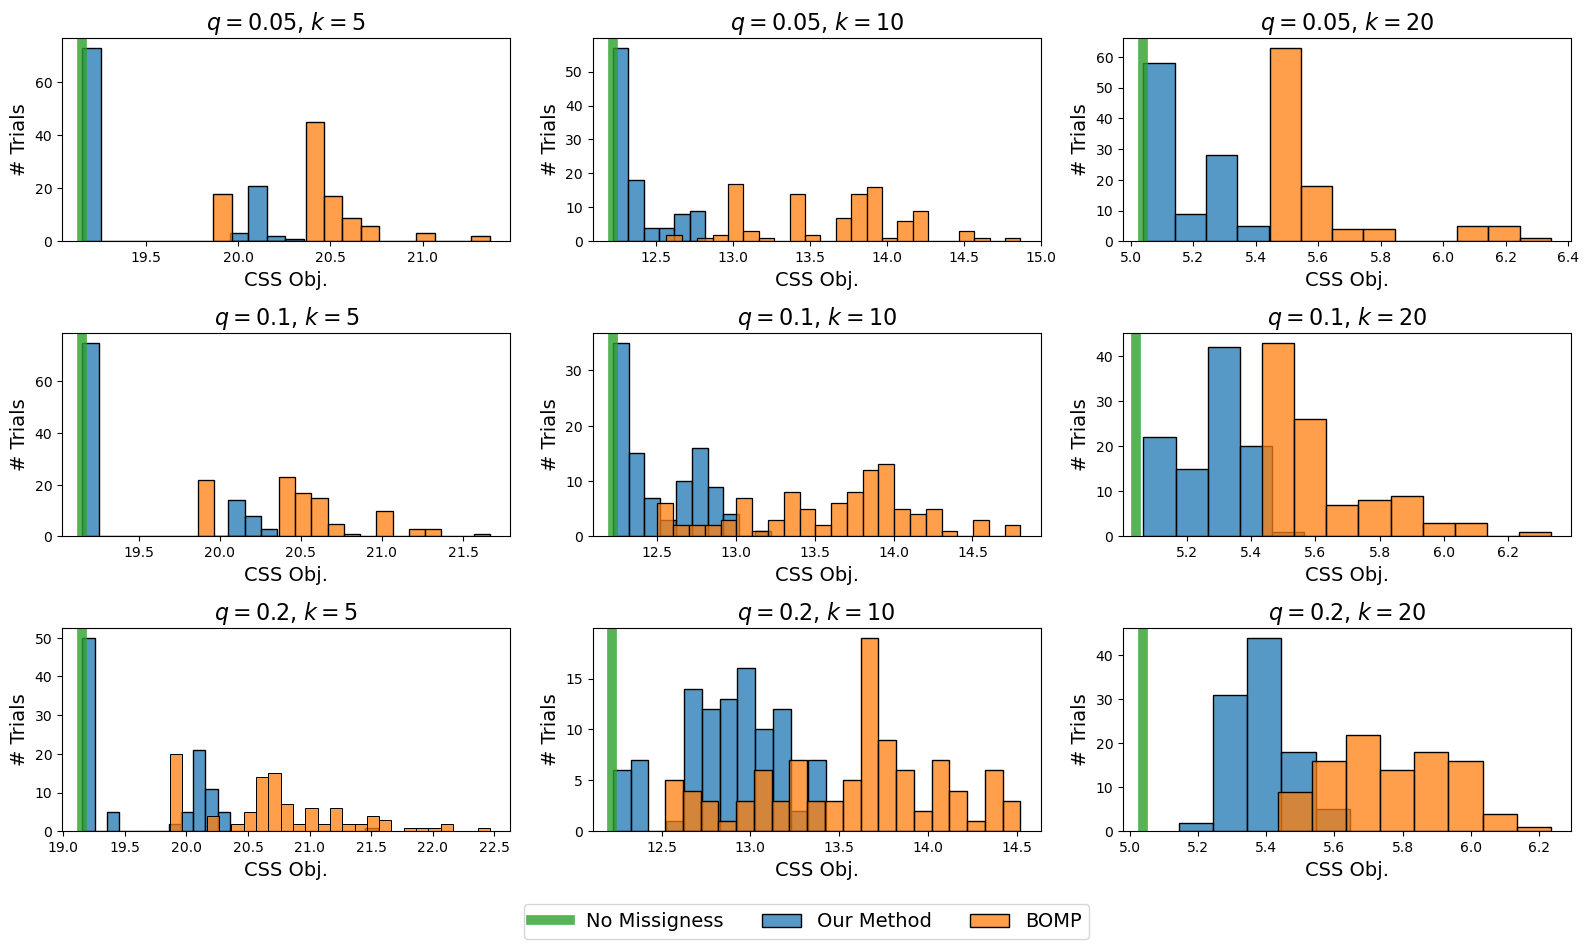

In [249]:

rows, cols = len(qs), len(ks)
keys = list(all_css_results.keys()) # assumes same keys for all_W_hat_results

fig, axes = plt.subplots(rows, cols, figsize=(16,9), squeeze=False)
for i in range(rows):
    for j in range(cols):
        ell = rows * i + j
        key = keys[ell]
        q = key[0]
        k = key[1]
        css_dict = all_css_results[key]
        
        pl = sns.histplot(css_dict['mask'], ax=axes[i,j], label='Our Method', color='tab:blue', binwidth=0.1)
        pl.set_title(f"$q={q}$, $k={k}$", fontsize=16)
        pl.set_xlabel("CSS Obj.", fontsize=14)
        pl.set_ylabel("# Trials", fontsize=14)
        sns.histplot(css_dict['block'], ax=axes[i, j],  label='BOMP', color='tab:orange', binwidth=0.1) 
        axes[i, j].axvline(x=target[k], linewidth=7, label='No Missigness', color='tab:green', alpha=0.8)

   
fig.legend(labels=['No Missigness', 'Our Method', 'BOMP'], prop={'size': 14}, bbox_to_anchor=(0.69, 0.00), ncols=3)   
plt.tight_layout()
plt.savefig("../figures/ozone_results.pdf", bbox_inches='tight')


In [237]:
#import pickle
#with open('all_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
#    pickle.dump(all_css_results, f, pickle.HIGHEST_PROTOCOL)